In [1]:
!pip install lightning
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install -q transformers
!pip install optuna-integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 24.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 68.6 MB/s eta 0:00:00:00:01:01m
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.69
    Uninstalling botocore-1.34.69:
      Successfully uninstalled botocore-1.34.69
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.3 requires botocore<1.34.70,>=1.34.41, but you have botocore 1.29.165 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 3.3 MB/s eta 0:00:00


In [2]:
import os
import random
from os import path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. I like it most for plot
import torch
from torch import cuda
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassPrecision,MulticlassF1Score,MulticlassRecall,MulticlassAccuracy

import torchvision.transforms as transforms
from torchvision.models import resnet152#resnet50 #resnet34,resnet101

from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoModel, AutoTokenizer

import lightning as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.samplers import TPESampler

wandb_logger = WandbLogger(log_model="all",project="Multimodal",name='Multi Modal Classification')

In [3]:
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(">>> SEEDED <<<")

set_seed(42)

>>> SEEDED <<<


In [5]:
df1 = pd.read_csv('/kaggle/input/proc2data/proc2.csv',index_col=0)
df1.head()

,file_name,text,not_offensive,slight_offensive,very_offensive
0,image_ (0).jpg,That moment after you throw up and your friend...,0,1,0
1,image_ (1).jpg,EVERYDAY IS CATURDAY IF you're a cat! I CATS,1,0,0
2,image_ (10).jpg,me\nfood at a potluck,1,0,0
3,image_ (100).jpg,My knowledge in love vs. My knowledge in theor...,0,1,0
4,image_ (101).jpg,My knowledge of Star \n Wars My knowledge of...,1,0,0


In [6]:
df1.shape

(3964, 5)

In [7]:
df2 = pd.read_csv('/kaggle/input/processed-csv/processed.csv',index_col=0)
df2.head()

,image_name,text_corrected,not_offensive,slight_offensive,very_offensive
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,1,0,0
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,1,0,0
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,1,0,0
3,image_4.png,10 Year Challenge - Sweet Dee Edition,0,1,0
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,0,1,0


In [8]:
df2.shape

(6992, 5)

In [9]:
df2.rename(columns={'image_name':'file_name','text_corrected':'text'},inplace=True)

In [10]:
#dfe = pd.read_csv('/kaggle/input/met-meme/E_text.csv', encoding='unicode_escape')
#dfe.head()

In [11]:
# dfe_lbl = pd.read_csv('/kaggle/input/met-meme/label_E.csv', encoding='unicode_escape',usecols=['file_name','offensiveness detection'])
# dfe_lbl.head()

In [12]:
# dfmet.loc[dfmet['offensiveness detection']==0,'not_offensive'] = 1
# dfmet.loc[dfmet['offensiveness detection']==1,'slight_offensive'] = 1
# dfmet.loc[dfmet['offensiveness detection']==2,'very_offensive'] = 1

In [13]:
#dfmet.drop(columns=['offensiveness detection'],inplace=True)

In [14]:
#dfmet.to_csv('proc2.csv')

In [15]:
df = pd.concat([df1,df2],axis=0)

In [16]:
df.shape

(10956, 5)

In [17]:
df['slight_offensive'].value_counts()
#df = df[df['offensive']!='hateful_offensive']#.unique()#.head()

slight_offensive
0    8638
1    2318
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


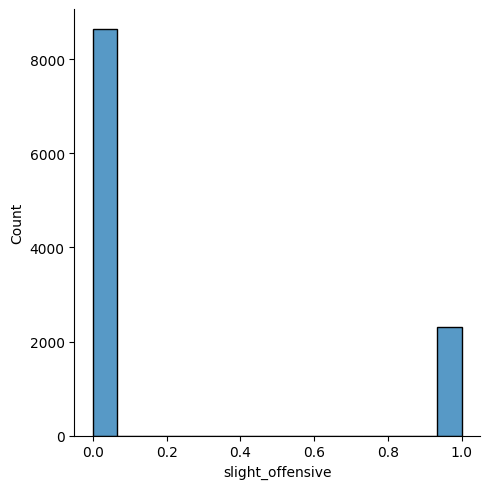

In [18]:
sns.displot(df['slight_offensive'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


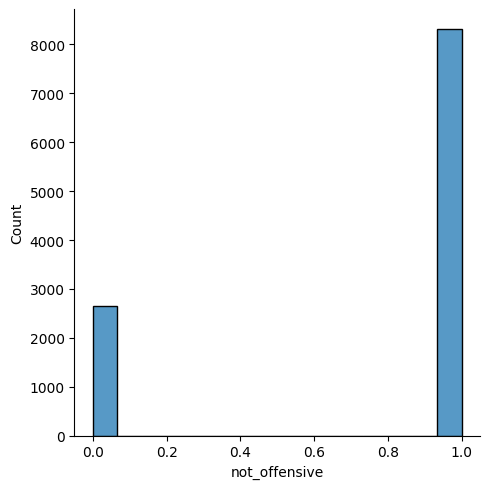

In [19]:
sns.displot(df['not_offensive'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


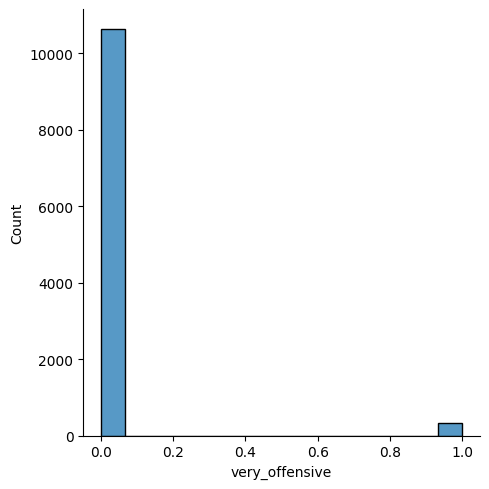

In [20]:
sns.displot(df['very_offensive'])

In [21]:
# offensiveness = ['not_offensive','slight_offensive','very_offensive']
# for c in offensiveness:
#     df[c] = 0

In [22]:
# df.loc[df['offensive']=='not_offensive','not_offensive'] = 1
# df.loc[df['offensive']=='slight','slight_offensive'] = 1
# df.loc[df['offensive']=='very_offensive','very_offensive'] = 1

In [23]:
# #df.loc[df['offensive']=='hateful_offensive','very_offensive'] = 1
# df.drop(columns=['offensive'],inplace=True)
# df.head()

In [24]:
# df.to_csv('/kaggle/working/processed1.csv')

In [25]:
# dfc = pd.read_csv('/kaggle/input/met-meme/label_E.csv', encoding='unicode_escape')
# dfc.head()

In [26]:
#df = pd.read_csv('/kaggle/input/dataset-with-hateful-offensive-dropped/processed.csv',index_col=0)

In [27]:
df = df.sample(frac=1, random_state=42)
#df.head()
N = len(df)
TRAIN_SIZE = int(N*0.8)
train_df = df.iloc[:TRAIN_SIZE]
test_df = df.iloc[TRAIN_SIZE:]
len(train_df),len(test_df)

(8764, 2192)

In [28]:
for c in df.columns[-3:]:
    print(sum(df[c]))

8310
2318
328


In [29]:
w1, w2, w3 = 8310/(8310+2318+328), 2318/(8310+2318+328), 328/(8310+2318+328)

In [30]:
weights = torch.tensor([w1,w2,w3])
weights.to(device)

tensor([0.7585, 0.2116, 0.0299], device='cuda:0')

In [31]:
IMAGES_URL1 = '/kaggle/input/memotion-dataset-7k/memotion_dataset_7k/images'
IMAGES_URL2 = '/kaggle/input/met-meme/Eimages/Eimages/Eimages'
IMAGE_COLUMN = 0
TEXT_COLUMN = 1
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
TEXT_MAX_LENGTH = 128

In [32]:
# Define the transform
transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [33]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [34]:
class MMDataSet(Dataset):
    def __init__(self, df, tokenizer, transform=None):
        self.transform = transform
        self.df = df.copy()
        self.image_folder1 = IMAGES_URL1
        self.image_folder2 = IMAGES_URL2
        self.transform = transform
        self.tokenizer = tokenizer
        self.length = len(df)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # label
        #print(idx)
        while True:
            try:
                y = torch.tensor(df.iloc[idx,-3:].to_numpy(dtype=np.int32),dtype=torch.float)

                # image
                i_name = self.df.iloc[idx,IMAGE_COLUMN]
                if '(' in i_name:
                    img_name = os.path.join(self.image_folder2, i_name)
                else:
                    img_name = os.path.join(self.image_folder1, i_name)
                #img_name = os.path.join(self.image_folder, self.df.iloc[idx,IMAGE_COLUMN])
                image = Image.open(img_name).convert('RGB') 
                if self.transform:
                    image = self.transform(image)         

                # text
                text = str(self.df.iloc[idx,TEXT_COLUMN]).lower()
                out = self.tokenizer(
                    text=text, 
                    max_length=TEXT_MAX_LENGTH,
                    padding='max_length',
                    truncation=True,
                    return_tensors="pt"
                )
                ids =  out['input_ids'].squeeze(),
                mask = out['attention_mask'].squeeze()
                #ids = out['input_ids']
                #mask = out['attention_mask']
                token_type_ids = out["token_type_ids"].squeeze()
                break
            except Exception as e:
                print(idx,e)
                idx = idx + 1
        return (image, ids[0], mask, token_type_ids), y

In [35]:
train_dataset = MMDataSet(train_df,tokenizer,transform)
test_dataset = MMDataSet(test_df,tokenizer,transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=3)
test_dataloader = DataLoader(test_dataset, batch_size=32,num_workers=3)

In [36]:
# Define the LightningModule
class MultiModel(pl.LightningModule):
    def __init__(self,learning_rate,cell_count,dropout):
        super(MultiModel, self).__init__()
        self.learning_rate = learning_rate
        self.cell_count = 768
        self.dropout = dropout
        self.accuracy = MulticlassAccuracy(num_classes=3,average=None)
        self.precision = MulticlassPrecision(num_classes=3,average=None)
        self.f1score = MulticlassF1Score(num_classes=3,average=None)
        self.recall = MulticlassRecall(num_classes=3,average=None)
        self.num_classes = 3
        #self.criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0,20.0,50.0]))        
        self.criterion = nn.CrossEntropyLoss()        
        self.resnet = resnet152(pretrained=True)#resnet101(pretrained=True)
        
        # Freeze all layers of ResNet except the custom head
        for param in self.resnet.parameters():
            param.requires_grad = False  
        for param in self.resnet.fc.parameters():
            param.requires_grad = True
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.pooler.dense.parameters():
            param.requires_grad = True
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.conv1d = nn.Conv1d(1000, 768, kernel_size=1)
        self.fc1 = nn.Linear(self.cell_count,self.cell_count)
        self.fc2 = nn.Linear(self.cell_count,self.cell_count)
        self.lrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid() #for activation 
        self.classifier = nn.Linear(self.cell_count*2, self.num_classes)
        #self.classifier = nn.Linear(1768, self.num_classes)
        self.dropout = nn.Dropout(p=self.dropout)

        
        
    def forward(self, x):
        image, ids, mask, token_type_ids = x
        img_features = self.resnet(image) # N x 1000
        img_features = self.lrelu(img_features)
        
        # Flatten the output of ResNet
        img_features = img_features.view(img_features.size(0), -1)
        
        # Pass through 1D convolutional layer
        img_features = img_features.unsqueeze(2)  # Add a singleton dimension for the 1D convolution
        img_features = self.conv1d(img_features)
        img_features = img_features.squeeze(2)  # Remove the singleton dimension
        img_features = self.sigmoid(img_features)
        img_features = self.fc1(img_features)
        img_features = self.sigmoid(img_features)
        img_features = self.dropout(img_features)
        #print(ids)
        _,txt_features = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False) # N x 768
        txt_features = self.fc2(txt_features)
        txt_features = self.sigmoid(txt_features)
        txt_features = self.dropout(txt_features)
        #print(type(txt_features))
        #_, txt_features = self.bert.forward(input_ids=ids, attention_mask=mask)
        #print(img_features.shape,txt_features.shape)
        x = torch.cat([img_features, txt_features],dim=1)
        x = self.classifier(x)
        x = self.sigmoid(x)
        return x#self.classifier(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        #print(loss)
        preds = torch.argmax(y_hat, dim=1)
        ys = torch.argmax(y,dim=1)
        #print(preds,ys,preds==ys)
        acc = (preds == ys).float().mean()
        #print(acc)
#         self.log('train/loss', loss,on_step=True,prog_bar=True,on_epoch=True)
#         self.log('train/acc', acc,prog_bar=True,on_epoch=True,on_step=True)
        #acc = self.accuracy(preds,ys)
        prec = self.precision(preds,ys)
        rec = self.recall(preds,ys)
        f1 = self.f1score(preds,ys)
        #acc = acc.cpu()
        prec = prec.cpu()
        rec = rec.cpu()
        f1 = f1.cpu()
        #acc = torch.dot(weights,acc)
        prec = torch.dot(weights,prec)
        rec = torch.dot(weights,rec)
        f1 = torch.dot(weights,f1)
        self.log('val/val_loss', loss,on_epoch=True,on_step=False,prog_bar=True)
        self.log('train_acc', acc, prog_bar=True,on_step=False,on_epoch=True)
        self.log('train_prec',prec,prog_bar=True,on_step=False,on_epoch=True)
        self.log('train_rec',rec,prog_bar=True,on_step=False,on_epoch=True)
        self.log('train_f1',f1,prog_bar=True,on_step=True,on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        #print(y.shape,y_hat.shape)
        loss = self.criterion(y_hat, y)
        ys = torch.argmax(y,dim=1)
        preds = torch.argmax(y_hat, dim=1)
        
        acc = (preds == ys).float().mean()
        #acc = self.accuracy(preds,ys)
        prec = self.precision(preds,ys)
        rec = self.recall(preds,ys)
        f1 = self.f1score(preds,ys)
        #print(acc.device,weights.device)
        #acc = acc.cpu()
        prec = prec.cpu()
        rec = rec.cpu()
        f1 = f1.cpu()
        #weights.to('cpu')
        #print(acc.device,weights.device)
        #acc = torch.dot(weights,acc)
        prec = torch.dot(weights,prec)
        rec = torch.dot(weights,rec)
        f1 = torch.dot(weights,f1)
        
        self.log('val/val_loss', loss,on_epoch=True,on_step=False,prog_bar=True)
        self.log('val_acc', acc, prog_bar=True,on_step=False,on_epoch=True)
        self.log('val_prec',prec,prog_bar=True,on_step=False,on_epoch=True)
        self.log('val_rec',rec,prog_bar=True,on_step=False,on_epoch=True)
        self.log('val_f1',f1,prog_bar=True,on_step=True,on_epoch=True)
        return acc
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def configure_callbacks(self):
        """Configures the ModelCheckpoint callback."""
        checkpoint_callback = ModelCheckpoint(
            monitor='val_acc',  # Monitor validation accuracy
            dirpath='./checkpoints',  # Directory to save checkpoints
            filename='best_model',  # Filename pattern
            save_top_k=1,  # Save only the best model
            mode='max',  # Save model with highest accuracy
            verbose=True
        )
        return [checkpoint_callback]  # Return a list of callbacks

In [37]:
def objective(trial: optuna.trial.Trial) -> float:
    # We optimize the number of layers, hidden units in each layer and dropouts.
    
    learning_rate = 0.01#trial.suggest_float("learning_rate",1e-4,1e-3
    cell_count = 10#trial.suggest_int("cell_count",2, 50)
    dropout = 0.3#trial.suggest_float('dropout',0.2,0.7)
    print(f'Training with learning rate:{learning_rate}, cell count:{cell_count}, and dropout:{dropout}')
    model = MultiModel(learning_rate = learning_rate, dropout=dropout,cell_count=cell_count)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    callbacks = model.configure_callbacks()

    trainer = pl.Trainer(max_epochs=600, devices=1, accelerator="auto",callbacks=callbacks)

    trainer.fit(model, train_dataloader, test_dataloader)
    
    return trainer.callback_metrics["val_prec"].item()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=1)
best_trial = study.best_trial
print(best_trial.params)
print(best_trial.value)

[I 2024-05-05 08:34:22,534] A new study created in memory with name: no-name-bded8b6a-5ea2-4a68-a3b2-65f1db81267a
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training with learning rate:0.01, cell count:10, and dropout:0.3


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 153MB/s]  


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
2024-05-05 08:34:30.360972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 08:34:30.361123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 08:34:30.469568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICE

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

3933 image file is truncated


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3412 image file is truncated


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 274: 'val_acc' reached 0.76232 (best 0.76232), saving model to '/kaggle/working/checkpoints/best_model.ckpt' as top 1
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3933 image file is truncated
3412 image file is truncated


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 548: 'val_acc' was not in top 1
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3933 image file is truncated
3412 image file is truncated


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 822: 'val_acc' was not in top 1


3412 image file is truncated


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3933 image file is truncated


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 1096: 'val_acc' was not in top 1
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3933 image file is truncated
3412 image file is truncated


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 1370: 'val_acc' was not in top 1


3933 image file is truncated


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3412 image file is truncated


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 1644: 'val_acc' was not in top 1
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3933 image file is truncated
3412 image file is truncated


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 1918: 'val_acc' was not in top 1
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3412 image file is truncated


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3933 image file is truncated


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 2192: 'val_acc' was not in top 1
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3412 image file is truncated
3933 image file is truncated


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 2466: 'val_acc' was not in top 1
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3933 image file is truncated


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3412 image file is truncated


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 2740: 'val_acc' was not in top 1


3933 image file is truncated


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3412 image file is truncated
